#  Multi-Factor CNN Training for Super-Resolution - CoSiBD Dataset

##  Project Description

This notebook implements **multi-factor training** of a **Convolutional Neural Network (CNN)** for super-resolution of temporal signals using the **CoSiBD** (Complex Signal Benchmark Dataset).

###  Objective
Train **4 CNN models** with different upsampling factors in a single sequential execution:
- **Input**: Subsampled signals with varying resolutions
- **Output**: High-resolution signals (**5,000 samples**)
- **Upsampling factors**: 5x, 10x, 20x, 33x

### Training Strategy
For each upsampling factor:
1. Load appropriate low-resolution data (1000, 500, 250, 150 samples)
2. Train CNN model with encoder-decoder architecture
3. Save model with factor-specific naming: `best_model_upsample{factor}x.pth`
4. Generate and save results in factor-specific directories
5. Compare all models at the end

###  Model Architecture
**TimeSeriesSRNet** - Encoder-decoder CNN:
- **Encoder**: Extracts features with convolutional layers (64, 128, 256 channels)
- **Upsampler**: Increases resolution with linear upsampling + refinement convolutions
- **Parametric upsampling factor**: Adjusts automatically for each training run

### Dataset Organization
Training uses 4 different input resolutions:
- 1000 samples → 5000 samples (5x upsampling)
- 500 samples → 5000 samples (10x upsampling)
- 250 samples → 5000 samples (20x upsampling)
- 150 samples → 5000 samples (33x upsampling)

Each dataset contains:
- **Training**: 2,000 signals
- **Validation**: 500 signals

---

## 📦 1. Import Required Libraries

Import all necessary libraries for deep learning, data manipulation, and visualization.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob
from pathlib import Path
import csv
from datetime import datetime
import json

# Custom module
import temana as tm

print("✅ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")

# Configure device with support for Mac GPU (MPS)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("🎮 NVIDIA GPU detected (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Apple Silicon GPU detected (MPS)")
else:
    device = torch.device("cpu")
    print("💻 Using CPU")

print(f"🖥️  Computing device: {device}")

✅ Libraries imported successfully
PyTorch version: 2.9.1
🍎 Apple Silicon GPU detected (MPS)
🖥️  Computing device: mps


## ⚙️ 2. Multi-Factor Configuration

Define training parameters for all upsampling factors.

In [7]:
# ============================================
# MULTI-FACTOR TRAINING CONFIGURATION
# ============================================

# Upsampling factors to train
INPUT_SIZES = [1000, 500, 250, 150]  # Low-resolution signal sizes
OUTPUT_SIZE = 5000  # High-resolution signal size (constant)
UPSAMPLE_FACTORS = [OUTPUT_SIZE // size for size in INPUT_SIZES]  # [5, 10, 20, 33]

# Data directories
DATA_DIR = Path("./data_multifactor")

# Training hyperparameters (same for all factors)
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
WEIGHT_DECAY = 1e-5

# Validation and early stopping configuration
VALIDATION_FREQUENCY = 10  # Validate every N epochs
EARLY_STOPPING_PATIENCE = 3  # Stop if no improvement in 3 validations (30 epochs)

# Model configuration
HIDDEN_CHANNELS = [64, 128, 256]  # Channels in encoder

# Output directories
MODELS_DIR = Path("./models_multifactor")
RESULTS_DIR = Path("./results_multifactor")
MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

# DataLoader configuration
use_workers = 4 if device.type == 'cuda' else 0
use_pin_memory = (device.type == 'cuda')

print("="*60)
print("MULTI-FACTOR TRAINING CONFIGURATION")
print("="*60)
print(f"📊 Input sizes: {INPUT_SIZES}")
print(f"📊 Output size: {OUTPUT_SIZE}")
print(f"⚡ Upsampling factors: {UPSAMPLE_FACTORS}")
print(f"🔢 Batch size: {BATCH_SIZE}")
print(f"📈 Learning rate: {LEARNING_RATE}")
print(f"🔁 Epochs per factor: {NUM_EPOCHS}")
print(f"✅ Validation frequency: {VALIDATION_FREQUENCY} epochs")
print(f"🛑 Early stopping patience: {EARLY_STOPPING_PATIENCE} validations")
print(f"💾 Models directory: {MODELS_DIR}")
print(f"📁 Results directory: {RESULTS_DIR}")
print(f"⚙️  Workers: {use_workers}, Pin memory: {use_pin_memory}")
print("="*60)

MULTI-FACTOR TRAINING CONFIGURATION
📊 Input sizes: [1000, 500, 250, 150]
📊 Output size: 5000
⚡ Upsampling factors: [5, 10, 20, 33]
🔢 Batch size: 16
📈 Learning rate: 0.001
🔁 Epochs per factor: 50
✅ Validation frequency: 10 epochs
🛑 Early stopping patience: 3 validations
💾 Models directory: models_multifactor
📁 Results directory: results_multifactor
⚙️  Workers: 0, Pin memory: False


## 🏗️ 3. Model Architecture Definition

Define the TimeSeriesSRNet CNN model with parametric upsampling factor.

In [8]:
class TimeSeriesSRNet(nn.Module):
    """
    Convolutional Neural Network for Super-Resolution of Time Series.
    
    Encoder-Decoder Architecture:
    - Encoder: Extracts multi-scale features
    - Upsampler: Increases resolution and refines the signal
    
    Args:
        input_size (int): Input signal length
        output_size (int): Desired output signal length
        hidden_channels (list): Channels in each encoder layer
    """
    def __init__(self, input_size=150, output_size=5000, hidden_channels=[64, 128, 256]):
        super(TimeSeriesSRNet, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        # ==================== ENCODER ====================
        # Extracts hierarchical features from the signal
        self.encoder = nn.Sequential(
            # Layer 1: 1 → 64 channels
            nn.Conv1d(1, hidden_channels[0], kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            
            # Layer 2: 64 → 128 channels
            nn.Conv1d(hidden_channels[0], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            
            # Layer 3: 128 → 256 channels
            nn.Conv1d(hidden_channels[1], hidden_channels[2], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[2]),
            nn.ReLU(inplace=True),
        )
        
        # ==================== UPSAMPLER ====================
        # Increases resolution and refines the signal
        self.upsample = nn.Sequential(
            # Linear upsampling to exact output size
            nn.Upsample(size=output_size, mode='linear', align_corners=True),
            
            # Refinement: 256 → 128 channels
            nn.Conv1d(hidden_channels[2], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            
            # Refinement: 128 → 64 channels
            nn.Conv1d(hidden_channels[1], hidden_channels[0], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            
            # Output: 64 → 1 channel (final signal)
            nn.Conv1d(hidden_channels[0], 1, kernel_size=9, stride=1, padding=4)
        )
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Tensor [batch_size, 1, input_size]
        
        Returns:
            Tensor [batch_size, 1, output_size]
        """
        features = self.encoder(x)
        output = self.upsample(features)
        return output

print("✅ TimeSeriesSRNet architecture defined")

✅ TimeSeriesSRNet architecture defined


## 📂 4. Data Loading Functions

Define functions to load signals from text files.

In [9]:
def load_signals(low_res_dir, high_res_dir, expected_low_size, expected_high_size):
    """
    Load signals from .txt files
    
    Args:
        low_res_dir: Directory with low-resolution signals
        high_res_dir: Directory with high-resolution signals
        expected_low_size: Expected size of low-resolution signals
        expected_high_size: Expected size of high-resolution signals
    
    Returns:
        x_data: Tensor [N, expected_low_size] - input signals
        y_data: Tensor [N, expected_high_size] - target signals
    """
    # Get file lists
    low_files = sorted(glob.glob(str(low_res_dir / "*.txt")))
    high_files = sorted(glob.glob(str(high_res_dir / "*.txt")))
    
    assert len(low_files) == len(high_files), f"Different number of files! Low: {len(low_files)}, High: {len(high_files)}"
    assert len(low_files) > 0, f"No files found in {low_res_dir}"
    
    x_list = []
    y_list = []
    
    print(f"📁 Loading {len(low_files)} signals from {low_res_dir.parent.name}/{low_res_dir.name}...")
    
    for low_file, high_file in tqdm(zip(low_files, high_files), total=len(low_files), leave=False):
        # Read files
        low_signal = np.loadtxt(low_file, dtype=np.float32)
        high_signal = np.loadtxt(high_file, dtype=np.float32)
        
        # Verify sizes
        assert len(low_signal) == expected_low_size, \
            f"Incorrect low signal size: {len(low_signal)} (expected {expected_low_size})"
        assert len(high_signal) == expected_high_size, \
            f"Incorrect high signal size: {len(high_signal)} (expected {expected_high_size})"
        
        x_list.append(low_signal)
        y_list.append(high_signal)
    
    # Convert to tensors
    x_data = torch.tensor(np.array(x_list), dtype=torch.float32)
    y_data = torch.tensor(np.array(y_list), dtype=torch.float32)
    
    return x_data, y_data

print("✅ Data loading function defined")

✅ Data loading function defined


## 🔁 5. Multi-Factor Training Loop

Train models sequentially for each upsampling factor.

In [10]:
# Dictionary to store results for all factors
all_results = {}

print("\n" + "="*60)
print("🚀 STARTING MULTI-FACTOR TRAINING")
print("="*60)

# Loop over all upsampling factors
for input_size, upsample_factor in zip(INPUT_SIZES, UPSAMPLE_FACTORS):
    
    print(f"\n{'#'*60}")
    print(f"# TRAINING MODEL: {upsample_factor}x UPSAMPLING")
    print(f"# Input: {input_size} samples → Output: {OUTPUT_SIZE} samples")
    print(f"{'#'*60}\n")
    
    # ==================== DATA LOADING ====================
    factor_data_dir = DATA_DIR / f"{input_size}_samples"
    train_low_dir = factor_data_dir / "train" / "low_res"
    train_high_dir = factor_data_dir / "train" / "high_res"
    val_low_dir = factor_data_dir / "validation" / "low_res"
    val_high_dir = factor_data_dir / "validation" / "high_res"
    
    # Check if directories exist
    if not train_low_dir.exists():
        print(f"⚠️  WARNING: Data directory not found: {train_low_dir}")
        print(f"   Skipping {upsample_factor}x upsampling factor")
        continue
    
    print("="*60)
    print("LOADING DATA")
    print("="*60)
    
    # Load training data
    x_train, y_train = load_signals(train_low_dir, train_high_dir, input_size, OUTPUT_SIZE)
    print(f"✅ Train - Input: {x_train.shape}, Output: {y_train.shape}")
    
    # Load validation data
    x_val, y_val = load_signals(val_low_dir, val_high_dir, input_size, OUTPUT_SIZE)
    print(f"✅ Validation - Input: {x_val.shape}, Output: {y_val.shape}")
    
    # Create datasets
    train_dataset = tm.MyDataset(x_train, y_train)
    val_dataset = tm.MyDataset(x_val, y_val)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=use_workers,
        pin_memory=use_pin_memory
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=use_workers,
        pin_memory=use_pin_memory
    )
    
    print(f"✅ DataLoaders created - Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
    
    # ==================== MODEL CREATION ====================
    print("\n" + "="*60)
    print("CREATING MODEL")
    print("="*60)
    
    model = TimeSeriesSRNet(
        input_size=input_size,
        output_size=OUTPUT_SIZE,
        hidden_channels=HIDDEN_CHANNELS
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"✅ Model created for {upsample_factor}x upsampling")
    print(f"📊 Total parameters: {total_params:,}")
    print(f"🔧 Trainable parameters: {trainable_params:,}")
    
    # ==================== TRAINING SETUP ====================
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopped = False
    
    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)
    print(f"⚡ Validation every {VALIDATION_FREQUENCY} epochs")
    print(f"🛑 Early stopping: {EARLY_STOPPING_PATIENCE} validations without improvement")
    print("="*60)
    
    # ==================== TRAINING LOOP ====================
    for epoch in range(NUM_EPOCHS):
        # Training mode
        model.train()
        train_loss = 0.0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
        for batch_x, batch_y in train_bar:
            # Move data to device and add channel dimension
            batch_x = batch_x.unsqueeze(1).to(device)  # [batch, 1, INPUT_SIZE]
            batch_y = batch_y.unsqueeze(1).to(device)  # [batch, 1, OUTPUT_SIZE]
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_x)
            
            # Calculate loss
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate loss
            train_loss += loss.item()
            train_bar.set_postfix({'loss': f'{loss.item():.6f}'})
        
        # Average training loss
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Print training loss
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {avg_train_loss:.6f}", end="")
        
        # ==================== VALIDATION (every N epochs) ====================
        if (epoch + 1) % VALIDATION_FREQUENCY == 0 or (epoch + 1) == NUM_EPOCHS:
            model.eval()
            val_loss = 0.0
            
            with torch.no_grad():
                val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)
                for batch_x, batch_y in val_bar:
                    batch_x = batch_x.unsqueeze(1).to(device)
                    batch_y = batch_y.unsqueeze(1).to(device)
                    
                    outputs = model(batch_x)
                    loss = criterion(outputs, batch_y)
                    
                    val_loss += loss.item()
                    val_bar.set_postfix({'loss': f'{loss.item():.6f}'})
            
            # Average validation loss
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            print(f" | Val Loss: {avg_val_loss:.6f}")
            
            # Save best model and check early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                checkpoint_path = MODELS_DIR / f"best_model_upsample{upsample_factor}x.pth"
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': avg_train_loss,
                    'val_loss': avg_val_loss,
                    'upsample_factor': upsample_factor,
                    'input_size': input_size,
                    'output_size': OUTPUT_SIZE
                }, checkpoint_path)
                print(f"  💾 Best model saved! (val_loss: {avg_val_loss:.6f})")
            else:
                patience_counter += 1
                print(f"  ⏳ No improvement ({patience_counter}/{EARLY_STOPPING_PATIENCE})")
                
                # Early stopping
                if patience_counter >= EARLY_STOPPING_PATIENCE:
                    print(f"\n🛑 EARLY STOPPING: No improvement in {EARLY_STOPPING_PATIENCE * VALIDATION_FREQUENCY} epochs")
                    early_stopped = True
                    break
        else:
            print()  # New line if no validation
        
        print("-" * 60)
    
    # ==================== SAVE RESULTS FOR THIS FACTOR ====================
    print("\n" + "="*60)
    if early_stopped:
        print(f"⏹️  TRAINING STOPPED AT EPOCH {epoch+1}/{NUM_EPOCHS}")
    else:
        print("✅ TRAINING COMPLETED")
    print("="*60)
    print(f"🏆 Best validation loss: {best_val_loss:.6f}")
    
    # Create results directory for this factor
    factor_results_dir = RESULTS_DIR / f"{upsample_factor}x"
    factor_results_dir.mkdir(exist_ok=True)
    
    # Save loss curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.title(f'Training Loss - {upsample_factor}x Upsampling', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
    plt.xlabel('Validation Checkpoint', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.title(f'Validation Loss - {upsample_factor}x Upsampling', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(factor_results_dir / 'loss_curves.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✅ Loss curves saved to {factor_results_dir / 'loss_curves.png'}")
    
    # Save loss history to CSV
    with open(factor_results_dir / 'loss_history.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Epoch', 'Train_Loss', 'Val_Loss'])
        for i, train_loss in enumerate(train_losses, 1):
            val_loss = val_losses[i // VALIDATION_FREQUENCY] if i % VALIDATION_FREQUENCY == 0 and (i // VALIDATION_FREQUENCY) < len(val_losses) else ''
            writer.writerow([i, train_loss, val_loss])
    
    print(f"✅ Loss history saved to {factor_results_dir / 'loss_history.csv'}")
    
    # Store results for comparison
    all_results[upsample_factor] = {
        'input_size': input_size,
        'output_size': OUTPUT_SIZE,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'total_epochs': len(train_losses),
        'early_stopped': early_stopped,
        'total_params': total_params
    }
    
    print(f"\n✅ Completed training for {upsample_factor}x upsampling")
    print("="*60)

print("\n" + "="*60)
print("🎉 ALL TRAINING COMPLETED!")
print("="*60)
print(f"✅ Trained {len(all_results)} models successfully")
for factor in sorted(all_results.keys()):
    print(f"   - {factor}x upsampling: Best Val Loss = {all_results[factor]['best_val_loss']:.6f}")
print("="*60)


🚀 STARTING MULTI-FACTOR TRAINING

############################################################
# TRAINING MODEL: 5x UPSAMPLING
# Input: 1000 samples → Output: 5000 samples
############################################################

LOADING DATA
📁 Loading 2000 signals from train/low_res...


✅ Train - Input: torch.Size([2000, 1000]), Output: torch.Size([2000, 5000])
📁 Loading 500 signals from validation/low_res...


✅ Validation - Input: torch.Size([500, 1000]), Output: torch.Size([500, 5000])
✅ DataLoaders created - Train batches: 125, Val batches: 32

CREATING MODEL
✅ Model created for 5x upsampling
📊 Total parameters: 412,673
🔧 Trainable parameters: 412,673

STARTING TRAINING
⚡ Validation every 10 epochs
🛑 Early stopping: 3 validations without improvement

STARTING TRAINING
⚡ Validation every 10 epochs
🛑 Early stopping: 3 validations without improvement


Epoch [1/50] - Train Loss: 1.630315
------------------------------------------------------------


Epoch [2/50] - Train Loss: 1.237638
------------------------------------------------------------


Epoch [3/50] - Train Loss: 1.017385
------------------------------------------------------------


Epoch [4/50] - Train Loss: 1.048048
------------------------------------------------------------


Epoch [5/50] - Train Loss: 1.040546
------------------------------------------------------------


Epoch [6/50] - Train Loss: 1.124424
------------------------------------------------------------


Epoch [7/50] - Train Loss: 0.974286
------------------------------------------------------------


Epoch [8/50] - Train Loss: 1.210860
------------------------------------------------------------


Epoch [9/50] - Train Loss: 0.957148
------------------------------------------------------------


Epoch [10/50] - Train Loss: 1.152791

 | Val Loss: 0.165910
  💾 Best model saved! (val_loss: 0.165910)
------------------------------------------------------------


Epoch [11/50] - Train Loss: 1.069022
------------------------------------------------------------


Epoch [12/50] - Train Loss: 1.184270
------------------------------------------------------------


Epoch [13/50] - Train Loss: 1.032721
------------------------------------------------------------


Epoch [14/50] - Train Loss: 0.910320
------------------------------------------------------------


Epoch [15/50] - Train Loss: 0.986297
------------------------------------------------------------


Epoch [16/50] - Train Loss: 0.995212
------------------------------------------------------------


Epoch [17/50] - Train Loss: 1.110153
------------------------------------------------------------


Epoch [18/50] - Train Loss: 0.998836
------------------------------------------------------------


Epoch [19/50] - Train Loss: 0.985883
------------------------------------------------------------


Epoch [20/50] - Train Loss: 1.034920

 | Val Loss: 0.169595
  ⏳ No improvement (1/3)
------------------------------------------------------------


Epoch [21/50] - Train Loss: 1.062235
------------------------------------------------------------


Epoch [22/50] - Train Loss: 0.877675
------------------------------------------------------------


Epoch [23/50] - Train Loss: 0.873927
------------------------------------------------------------


Epoch [24/50] - Train Loss: 1.024121
------------------------------------------------------------


Epoch [25/50] - Train Loss: 1.181966
------------------------------------------------------------


Epoch [26/50] - Train Loss: 0.931622
------------------------------------------------------------


Epoch [27/50] - Train Loss: 1.057040
------------------------------------------------------------


Epoch [28/50] - Train Loss: 1.060694
------------------------------------------------------------


Epoch [29/50] - Train Loss: 0.982345
------------------------------------------------------------


Epoch [30/50] - Train Loss: 0.951009

 | Val Loss: 0.084546
  💾 Best model saved! (val_loss: 0.084546)
------------------------------------------------------------


Epoch [31/50] - Train Loss: 1.078617
------------------------------------------------------------


Epoch [32/50] - Train Loss: 0.897856
------------------------------------------------------------


Epoch [33/50] - Train Loss: 1.023953
------------------------------------------------------------


Epoch [34/50] - Train Loss: 0.947375
------------------------------------------------------------


Epoch [35/50] - Train Loss: 0.877760
------------------------------------------------------------


Epoch [36/50] - Train Loss: 0.808468
------------------------------------------------------------


Epoch [37/50] - Train Loss: 1.074169
------------------------------------------------------------


Epoch [38/50] - Train Loss: 1.027237
------------------------------------------------------------


Epoch [39/50] - Train Loss: 0.910261
------------------------------------------------------------


Epoch [40/50] - Train Loss: 0.903357

 | Val Loss: 0.114250
  ⏳ No improvement (1/3)
------------------------------------------------------------


Epoch [41/50] - Train Loss: 1.180894
------------------------------------------------------------


Epoch [42/50] - Train Loss: 0.855203
------------------------------------------------------------


Epoch [43/50] - Train Loss: 1.037372
------------------------------------------------------------


Epoch [44/50] - Train Loss: 1.035155
------------------------------------------------------------


Epoch [45/50] - Train Loss: 1.145060
------------------------------------------------------------


Epoch [46/50] - Train Loss: 1.090008
------------------------------------------------------------


Epoch [47/50] - Train Loss: 1.087812
------------------------------------------------------------


Epoch [48/50] - Train Loss: 1.036293
------------------------------------------------------------


Epoch [49/50] - Train Loss: 0.917392
------------------------------------------------------------


Epoch [50/50] - Train Loss: 0.963280

 | Val Loss: 0.127284
  ⏳ No improvement (2/3)
------------------------------------------------------------

✅ TRAINING COMPLETED
🏆 Best validation loss: 0.084546
✅ Loss curves saved to results_multifactor/5x/loss_curves.png
✅ Loss history saved to results_multifactor/5x/loss_history.csv

✅ Completed training for 5x upsampling

############################################################
# TRAINING MODEL: 10x UPSAMPLING
# Input: 500 samples → Output: 5000 samples
############################################################

LOADING DATA
📁 Loading 2000 signals from train/low_res...
✅ Loss curves saved to results_multifactor/5x/loss_curves.png
✅ Loss history saved to results_multifactor/5x/loss_history.csv

✅ Completed training for 5x upsampling

############################################################
# TRAINING MODEL: 10x UPSAMPLING
# Input: 500 samples → Output: 5000 samples
############################################################

LOADING DATA
📁 Loading 2000 signals from trai

✅ Train - Input: torch.Size([2000, 500]), Output: torch.Size([2000, 5000])
📁 Loading 500 signals from validation/low_res...


✅ Validation - Input: torch.Size([500, 500]), Output: torch.Size([500, 5000])
✅ DataLoaders created - Train batches: 125, Val batches: 32

CREATING MODEL
✅ Model created for 10x upsampling
📊 Total parameters: 412,673
🔧 Trainable parameters: 412,673

STARTING TRAINING
⚡ Validation every 10 epochs
🛑 Early stopping: 3 validations without improvement


Epoch [1/50] - Train Loss: 1.621707
------------------------------------------------------------


Epoch [2/50] - Train Loss: 1.264678
------------------------------------------------------------


Epoch [3/50] - Train Loss: 1.084427
------------------------------------------------------------


Epoch [4/50] - Train Loss: 1.113275
------------------------------------------------------------


Epoch [5/50] - Train Loss: 1.197272
------------------------------------------------------------


Epoch [6/50] - Train Loss: 1.008500
------------------------------------------------------------


Epoch [7/50] - Train Loss: 1.193612
------------------------------------------------------------


Epoch [8/50] - Train Loss: 1.121180
------------------------------------------------------------


Epoch [9/50] - Train Loss: 1.284038
------------------------------------------------------------


Epoch [10/50] - Train Loss: 1.039400

 | Val Loss: 0.182530
  💾 Best model saved! (val_loss: 0.182530)
------------------------------------------------------------


Epoch [11/50] - Train Loss: 1.220743
------------------------------------------------------------


Epoch [12/50] - Train Loss: 1.247609
------------------------------------------------------------


Epoch [13/50] - Train Loss: 1.132348
------------------------------------------------------------


Epoch [14/50] - Train Loss: 1.015218
------------------------------------------------------------


Epoch [15/50] - Train Loss: 1.147113
------------------------------------------------------------


Epoch [16/50] - Train Loss: 1.110477
------------------------------------------------------------


Epoch [17/50] - Train Loss: 0.949887
------------------------------------------------------------


Epoch [18/50] - Train Loss: 1.240430
------------------------------------------------------------


Epoch [19/50] - Train Loss: 0.929429
------------------------------------------------------------


Epoch [20/50] - Train Loss: 1.237094

 | Val Loss: 0.182072
  💾 Best model saved! (val_loss: 0.182072)
------------------------------------------------------------


Epoch [21/50] - Train Loss: 1.026949
------------------------------------------------------------


Epoch [22/50] - Train Loss: 1.182406
------------------------------------------------------------


Epoch [23/50] - Train Loss: 1.037275
------------------------------------------------------------


Epoch [24/50] - Train Loss: 1.031995
------------------------------------------------------------


Epoch [25/50] - Train Loss: 1.105367
------------------------------------------------------------


Epoch [26/50] - Train Loss: 1.129201
------------------------------------------------------------


Epoch [27/50] - Train Loss: 1.084097
------------------------------------------------------------


Epoch [28/50] - Train Loss: 1.100424
------------------------------------------------------------


Epoch [29/50] - Train Loss: 1.051384
------------------------------------------------------------


Epoch [30/50] - Train Loss: 1.168204

 | Val Loss: 0.195930
  ⏳ No improvement (1/3)
------------------------------------------------------------


Epoch [31/50] - Train Loss: 1.107079
------------------------------------------------------------


Epoch [32/50] - Train Loss: 1.034829
------------------------------------------------------------


Epoch [33/50] - Train Loss: 1.020773
------------------------------------------------------------


Epoch [34/50] - Train Loss: 1.025684
------------------------------------------------------------


Epoch [35/50] - Train Loss: 1.026770
------------------------------------------------------------


Epoch [36/50] - Train Loss: 1.051356
------------------------------------------------------------


Epoch [37/50] - Train Loss: 1.018263
------------------------------------------------------------


Epoch [38/50] - Train Loss: 1.307601
------------------------------------------------------------


Epoch [39/50] - Train Loss: 1.151144
------------------------------------------------------------


Epoch [40/50] - Train Loss: 0.899157

 | Val Loss: 0.152431
  💾 Best model saved! (val_loss: 0.152431)
------------------------------------------------------------


Epoch [41/50] - Train Loss: 1.133643
------------------------------------------------------------


Epoch [42/50] - Train Loss: 1.117847
------------------------------------------------------------


Epoch [43/50] - Train Loss: 1.102574
------------------------------------------------------------


Epoch [44/50] - Train Loss: 1.093552
------------------------------------------------------------


Epoch [45/50] - Train Loss: 1.123257
------------------------------------------------------------


Epoch [46/50] - Train Loss: 0.986733
------------------------------------------------------------


Epoch [47/50] - Train Loss: 0.957063
------------------------------------------------------------


Epoch [48/50] - Train Loss: 0.999803
------------------------------------------------------------


Epoch [49/50] - Train Loss: 0.923609
------------------------------------------------------------


Epoch [50/50] - Train Loss: 1.091930

 | Val Loss: 0.184326
  ⏳ No improvement (1/3)
------------------------------------------------------------

✅ TRAINING COMPLETED
🏆 Best validation loss: 0.152431
✅ Loss curves saved to results_multifactor/10x/loss_curves.png
✅ Loss history saved to results_multifactor/10x/loss_history.csv

✅ Completed training for 10x upsampling

############################################################
# TRAINING MODEL: 20x UPSAMPLING
# Input: 250 samples → Output: 5000 samples
############################################################

LOADING DATA
📁 Loading 2000 signals from train/low_res...
✅ Loss curves saved to results_multifactor/10x/loss_curves.png
✅ Loss history saved to results_multifactor/10x/loss_history.csv

✅ Completed training for 10x upsampling

############################################################
# TRAINING MODEL: 20x UPSAMPLING
# Input: 250 samples → Output: 5000 samples
############################################################

LOADING DATA
📁 Loading 2000 signals fro

✅ Train - Input: torch.Size([2000, 250]), Output: torch.Size([2000, 5000])
📁 Loading 500 signals from validation/low_res...


✅ Validation - Input: torch.Size([500, 250]), Output: torch.Size([500, 5000])
✅ DataLoaders created - Train batches: 125, Val batches: 32

CREATING MODEL
✅ Model created for 20x upsampling
📊 Total parameters: 412,673
🔧 Trainable parameters: 412,673

STARTING TRAINING
⚡ Validation every 10 epochs
🛑 Early stopping: 3 validations without improvement


Epoch [1/50] - Train Loss: 2.028176
------------------------------------------------------------


Epoch [2/50] - Train Loss: 1.686729
------------------------------------------------------------


Epoch [3/50] - Train Loss: 1.654416
------------------------------------------------------------


Epoch [4/50] - Train Loss: 1.511804
------------------------------------------------------------


Epoch [5/50] - Train Loss: 1.490881
------------------------------------------------------------


Epoch [6/50] - Train Loss: 1.390440
------------------------------------------------------------


Epoch [7/50] - Train Loss: 1.508528
------------------------------------------------------------


Epoch [8/50] - Train Loss: 1.571624
------------------------------------------------------------


Epoch [9/50] - Train Loss: 1.303941
------------------------------------------------------------


Epoch [10/50] - Train Loss: 1.520226

 | Val Loss: 0.504250
  💾 Best model saved! (val_loss: 0.504250)
------------------------------------------------------------


Epoch [11/50] - Train Loss: 1.480812
------------------------------------------------------------


Epoch [12/50] - Train Loss: 1.542182
------------------------------------------------------------


Epoch [13/50] - Train Loss: 1.336091
------------------------------------------------------------


Epoch [14/50] - Train Loss: 1.460623
------------------------------------------------------------


Epoch [15/50] - Train Loss: 1.428338
------------------------------------------------------------


Epoch [16/50] - Train Loss: 1.650214
------------------------------------------------------------


Epoch [17/50] - Train Loss: 1.487099
------------------------------------------------------------


Epoch [18/50] - Train Loss: 1.286249
------------------------------------------------------------


Epoch [19/50] - Train Loss: 1.339429
------------------------------------------------------------


Epoch [20/50] - Train Loss: 1.548031

 | Val Loss: 0.465990
  💾 Best model saved! (val_loss: 0.465990)
------------------------------------------------------------


Epoch [21/50] - Train Loss: 1.495973
------------------------------------------------------------


Epoch [22/50] - Train Loss: 1.251585
------------------------------------------------------------


Epoch [23/50] - Train Loss: 1.508083
------------------------------------------------------------


Epoch [24/50] - Train Loss: 1.529257
------------------------------------------------------------


Epoch [25/50] - Train Loss: 1.376458
------------------------------------------------------------


Epoch [26/50] - Train Loss: 1.300240
------------------------------------------------------------


Epoch [27/50] - Train Loss: 1.572970
------------------------------------------------------------


Epoch [28/50] - Train Loss: 1.412304
------------------------------------------------------------


Epoch [29/50] - Train Loss: 1.381935
------------------------------------------------------------


Epoch [30/50] - Train Loss: 1.324577

 | Val Loss: 0.437598
  💾 Best model saved! (val_loss: 0.437598)
------------------------------------------------------------


Epoch [31/50] - Train Loss: 1.402642
------------------------------------------------------------


Epoch [32/50] - Train Loss: 1.342251
------------------------------------------------------------


Epoch [33/50] - Train Loss: 1.409171
------------------------------------------------------------


Epoch [34/50] - Train Loss: 1.288522
------------------------------------------------------------


Epoch [35/50] - Train Loss: 1.502009
------------------------------------------------------------


Epoch [36/50] - Train Loss: 1.422254
------------------------------------------------------------


Epoch [37/50] - Train Loss: 1.424567
------------------------------------------------------------


Epoch [38/50] - Train Loss: 1.440319
------------------------------------------------------------


Epoch [39/50] - Train Loss: 1.395757
------------------------------------------------------------


Epoch [40/50] - Train Loss: 1.335885

 | Val Loss: 0.483000
  ⏳ No improvement (1/3)
------------------------------------------------------------


Epoch [41/50] - Train Loss: 1.283508
------------------------------------------------------------


Epoch [42/50] - Train Loss: 1.548233
------------------------------------------------------------


Epoch [43/50] - Train Loss: 1.258341
------------------------------------------------------------


Epoch [44/50] - Train Loss: 1.433086
------------------------------------------------------------


Epoch [45/50] - Train Loss: 1.354768
------------------------------------------------------------


Epoch [46/50] - Train Loss: 1.330120
------------------------------------------------------------


Epoch [47/50] - Train Loss: 1.433731
------------------------------------------------------------


Epoch [48/50] - Train Loss: 1.276246
------------------------------------------------------------


Epoch [49/50] - Train Loss: 1.424517
------------------------------------------------------------


Epoch [50/50] - Train Loss: 1.319439

 | Val Loss: 0.493568
  ⏳ No improvement (2/3)
------------------------------------------------------------

✅ TRAINING COMPLETED
🏆 Best validation loss: 0.437598
✅ Loss curves saved to results_multifactor/20x/loss_curves.png
✅ Loss history saved to results_multifactor/20x/loss_history.csv

✅ Completed training for 20x upsampling

############################################################
# TRAINING MODEL: 33x UPSAMPLING
# Input: 150 samples → Output: 5000 samples
############################################################

LOADING DATA
📁 Loading 2000 signals from train/low_res...


✅ Train - Input: torch.Size([2000, 150]), Output: torch.Size([2000, 5000])
📁 Loading 500 signals from validation/low_res...


✅ Validation - Input: torch.Size([500, 150]), Output: torch.Size([500, 5000])
✅ DataLoaders created - Train batches: 125, Val batches: 32

CREATING MODEL
✅ Model created for 33x upsampling
📊 Total parameters: 412,673
🔧 Trainable parameters: 412,673

STARTING TRAINING
⚡ Validation every 10 epochs
🛑 Early stopping: 3 validations without improvement


Epoch [1/50] - Train Loss: 2.879078
------------------------------------------------------------


Epoch [2/50] - Train Loss: 2.389095
------------------------------------------------------------


Epoch [3/50] - Train Loss: 2.189321
------------------------------------------------------------


Epoch [4/50] - Train Loss: 2.178314
------------------------------------------------------------


Epoch [5/50] - Train Loss: 2.377816
------------------------------------------------------------


Epoch [6/50] - Train Loss: 2.090896
------------------------------------------------------------


Epoch [7/50] - Train Loss: 2.001006
------------------------------------------------------------


Epoch [8/50] - Train Loss: 2.207437
------------------------------------------------------------


Epoch [9/50] - Train Loss: 2.166670
------------------------------------------------------------


Epoch [10/50] - Train Loss: 2.227530

 | Val Loss: 1.117682
  💾 Best model saved! (val_loss: 1.117682)
------------------------------------------------------------


Epoch [11/50] - Train Loss: 1.968401
------------------------------------------------------------


Epoch [12/50] - Train Loss: 2.180721
------------------------------------------------------------


Epoch [13/50] - Train Loss: 2.137300
------------------------------------------------------------


Epoch [14/50] - Train Loss: 2.068154
------------------------------------------------------------


Epoch [15/50] - Train Loss: 2.000816
------------------------------------------------------------


Epoch [16/50] - Train Loss: 2.087333
------------------------------------------------------------


Epoch [17/50] - Train Loss: 2.120654
------------------------------------------------------------


Epoch [18/50] - Train Loss: 1.969801
------------------------------------------------------------


Epoch [19/50] - Train Loss: 2.049801
------------------------------------------------------------


Epoch [20/50] - Train Loss: 2.116847

 | Val Loss: 1.069652
  💾 Best model saved! (val_loss: 1.069652)
------------------------------------------------------------


Epoch [21/50] - Train Loss: 1.957902
------------------------------------------------------------


Epoch [22/50] - Train Loss: 1.911903
------------------------------------------------------------


Epoch [23/50] - Train Loss: 2.067550
------------------------------------------------------------


Epoch [24/50] - Train Loss: 1.930896
------------------------------------------------------------


Epoch [25/50] - Train Loss: 2.121885
------------------------------------------------------------


Epoch [26/50] - Train Loss: 1.908489
------------------------------------------------------------


Epoch [27/50] - Train Loss: 2.029104
------------------------------------------------------------


Epoch [28/50] - Train Loss: 2.015037
------------------------------------------------------------


Epoch [29/50] - Train Loss: 1.990528
------------------------------------------------------------


Epoch [30/50] - Train Loss: 2.012838

 | Val Loss: 1.098050
  ⏳ No improvement (1/3)
------------------------------------------------------------


Epoch [31/50] - Train Loss: 1.975948
------------------------------------------------------------


Epoch [32/50] - Train Loss: 1.804195
------------------------------------------------------------


Epoch [33/50] - Train Loss: 1.998228
------------------------------------------------------------


Epoch [34/50] - Train Loss: 1.949094
------------------------------------------------------------


Epoch [35/50] - Train Loss: 1.945862
------------------------------------------------------------


Epoch [36/50] - Train Loss: 1.928195
------------------------------------------------------------


Epoch [37/50] - Train Loss: 2.127994
------------------------------------------------------------


Epoch [38/50] - Train Loss: 2.162269
------------------------------------------------------------


Epoch [39/50] - Train Loss: 2.016267
------------------------------------------------------------


Epoch [40/50] - Train Loss: 1.839229

 | Val Loss: 1.103515
  ⏳ No improvement (2/3)
------------------------------------------------------------


Epoch [41/50] - Train Loss: 1.983476
------------------------------------------------------------


Epoch [42/50] - Train Loss: 1.865296
------------------------------------------------------------


Epoch [43/50] - Train Loss: 1.930005
------------------------------------------------------------


Epoch [44/50] - Train Loss: 1.835053
------------------------------------------------------------


Epoch [45/50] - Train Loss: 1.942496
------------------------------------------------------------


Epoch [46/50] - Train Loss: 1.980937
------------------------------------------------------------


Epoch [47/50] - Train Loss: 1.954508
------------------------------------------------------------


Epoch [48/50] - Train Loss: 1.865531
------------------------------------------------------------


Epoch [49/50] - Train Loss: 1.789443
------------------------------------------------------------


Epoch [50/50] - Train Loss: 1.947358

 | Val Loss: 1.032622
  💾 Best model saved! (val_loss: 1.032622)
------------------------------------------------------------

✅ TRAINING COMPLETED
🏆 Best validation loss: 1.032622
✅ Loss curves saved to results_multifactor/33x/loss_curves.png
✅ Loss history saved to results_multifactor/33x/loss_history.csv

✅ Completed training for 33x upsampling

🎉 ALL TRAINING COMPLETED!
✅ Trained 4 models successfully
   - 5x upsampling: Best Val Loss = 0.084546
   - 10x upsampling: Best Val Loss = 0.152431
   - 20x upsampling: Best Val Loss = 0.437598
   - 33x upsampling: Best Val Loss = 1.032622
✅ Loss curves saved to results_multifactor/33x/loss_curves.png
✅ Loss history saved to results_multifactor/33x/loss_history.csv

✅ Completed training for 33x upsampling

🎉 ALL TRAINING COMPLETED!
✅ Trained 4 models successfully
   - 5x upsampling: Best Val Loss = 0.084546
   - 10x upsampling: Best Val Loss = 0.152431
   - 20x upsampling: Best Val Loss = 0.437598
   - 33x upsampling: Best Val Loss = 1.0326

## 📊 6. Comparison of All Models

Compare training results across all upsampling factors.

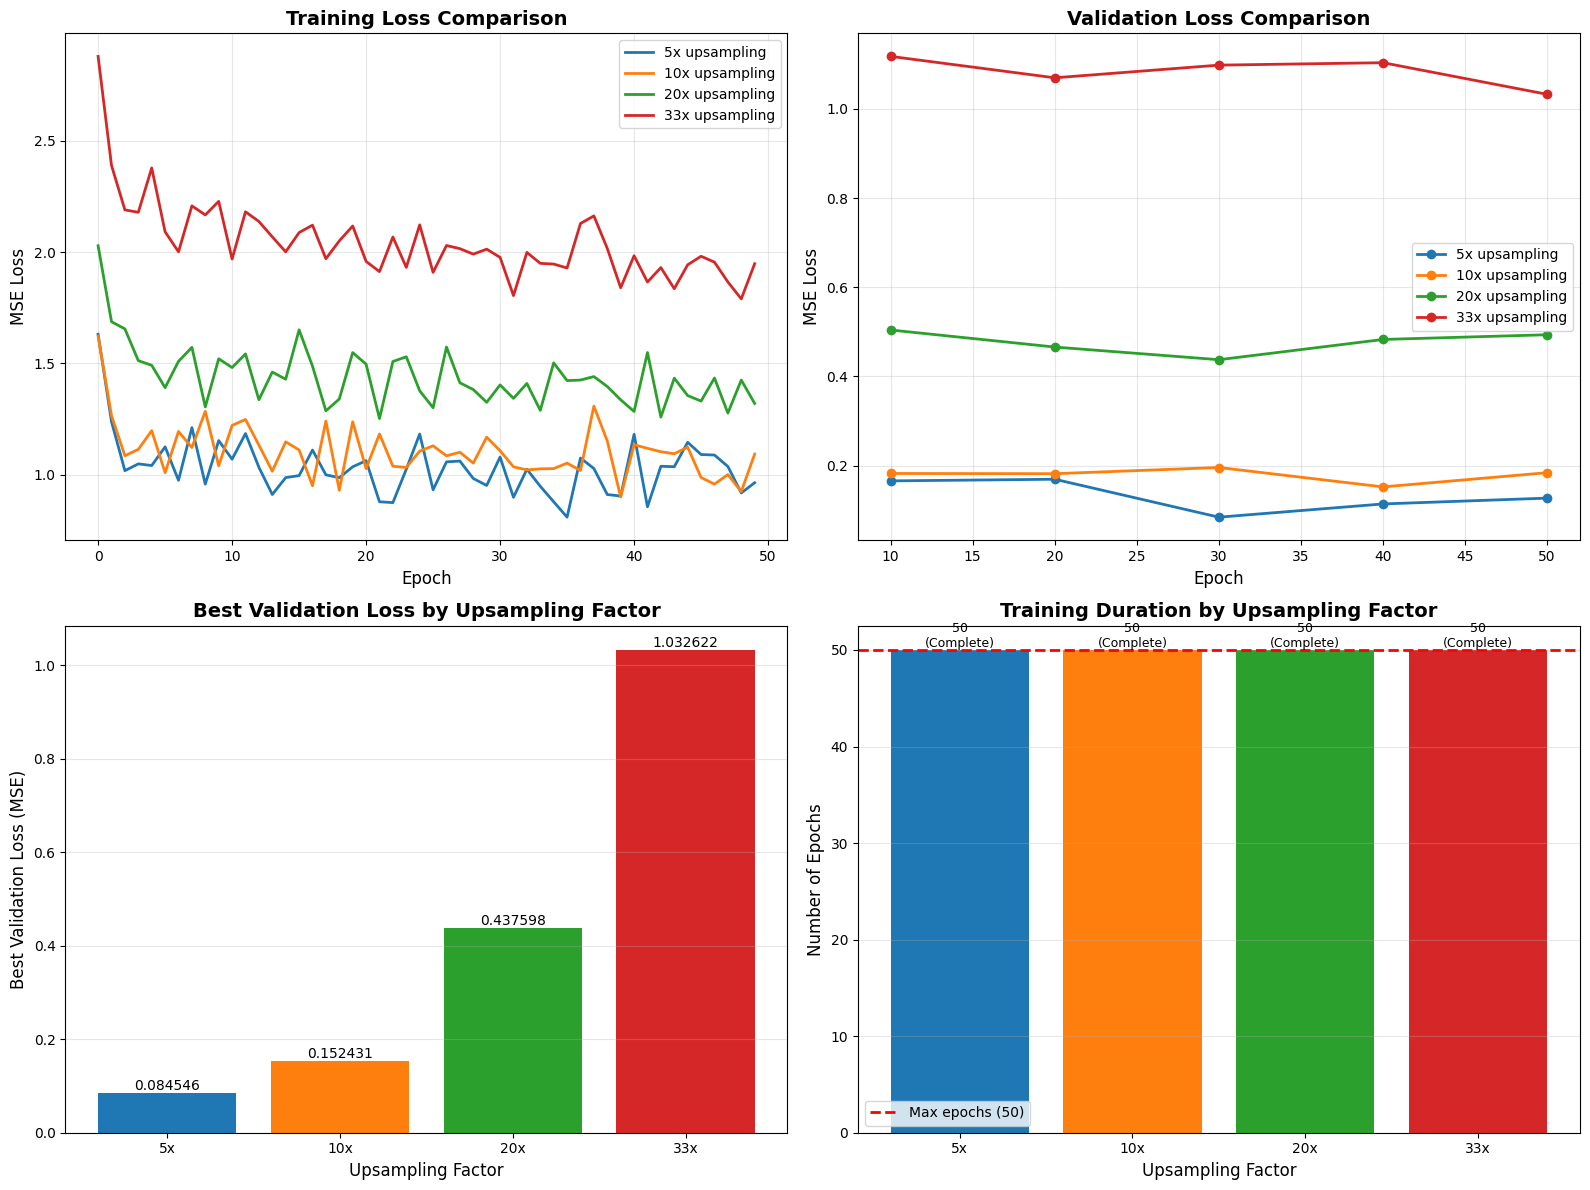

✅ Comparison plots saved to results_multifactor/multi_factor_comparison.png


In [11]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Training loss comparison
ax = axes[0, 0]
for factor in sorted(all_results.keys()):
    ax.plot(all_results[factor]['train_losses'], label=f'{factor}x upsampling', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Validation loss comparison
ax = axes[0, 1]
for factor in sorted(all_results.keys()):
    val_checkpoints = list(range(VALIDATION_FREQUENCY, all_results[factor]['total_epochs']+1, VALIDATION_FREQUENCY))
    if len(val_checkpoints) > len(all_results[factor]['val_losses']):
        val_checkpoints = val_checkpoints[:len(all_results[factor]['val_losses'])]
    ax.plot(val_checkpoints, all_results[factor]['val_losses'], label=f'{factor}x upsampling', 
            linewidth=2, marker='o')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Best validation loss by factor
ax = axes[1, 0]
factors = sorted(all_results.keys())
best_losses = [all_results[f]['best_val_loss'] for f in factors]
bars = ax.bar([f"{f}x" for f in factors], best_losses, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(factors)])
ax.set_xlabel('Upsampling Factor', fontsize=12)
ax.set_ylabel('Best Validation Loss (MSE)', fontsize=12)
ax.set_title('Best Validation Loss by Upsampling Factor', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, loss in zip(bars, best_losses):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{loss:.6f}', ha='center', va='bottom', fontsize=10)

# Plot 4: Training epochs by factor
ax = axes[1, 1]
epochs = [all_results[f]['total_epochs'] for f in factors]
bars = ax.bar([f"{f}x" for f in factors], epochs, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(factors)])
ax.axhline(y=NUM_EPOCHS, color='red', linestyle='--', linewidth=2, label=f'Max epochs ({NUM_EPOCHS})')
ax.set_xlabel('Upsampling Factor', fontsize=12)
ax.set_ylabel('Number of Epochs', fontsize=12)
ax.set_title('Training Duration by Upsampling Factor', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, ep, factor in zip(bars, epochs, factors):
    height = bar.get_height()
    label = f'{ep}\n({"Early Stop" if all_results[factor]["early_stopped"] else "Complete"})'
    ax.text(bar.get_x() + bar.get_width()/2., height,
            label, ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'multi_factor_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Comparison plots saved to {RESULTS_DIR / 'multi_factor_comparison.png'}")

## 🔮 7. Generate Prediction Examples for Each Factor

Load best models and create prediction visualizations.

In [12]:
print("\n" + "="*60)
print("GENERATING PREDICTION EXAMPLES")
print("="*60)

num_examples = 5

for input_size, upsample_factor in zip(INPUT_SIZES, UPSAMPLE_FACTORS):
    if upsample_factor not in all_results:
        print(f"⚠️  Skipping {upsample_factor}x - no trained model")
        continue
    
    print(f"\n📊 Generating examples for {upsample_factor}x upsampling...")
    
    # Load validation data for this factor
    factor_data_dir = DATA_DIR / f"{input_size}_samples"
    val_low_dir = factor_data_dir / "validation" / "low_res"
    val_high_dir = factor_data_dir / "validation" / "high_res"
    
    if not val_low_dir.exists():
        print(f"⚠️  Validation data not found for {upsample_factor}x")
        continue
    
    x_val, y_val = load_signals(val_low_dir, val_high_dir, input_size, OUTPUT_SIZE)
    
    # Load best model
    checkpoint_path = MODELS_DIR / f"best_model_upsample{upsample_factor}x.pth"
    if not checkpoint_path.exists():
        print(f"⚠️  Model not found: {checkpoint_path}")
        continue
    
    model = TimeSeriesSRNet(
        input_size=input_size,
        output_size=OUTPUT_SIZE,
        hidden_channels=HIDDEN_CHANNELS
    ).to(device)
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✅ Model loaded from epoch {checkpoint['epoch']}")
    
    # Select random examples
    indices = np.random.choice(len(x_val), min(num_examples, len(x_val)), replace=False)
    
    # Create results directory for this factor
    factor_results_dir = RESULTS_DIR / f"{upsample_factor}x"
    factor_results_dir.mkdir(exist_ok=True)
    
    # Generate combined plot
    fig, axes = plt.subplots(num_examples, 1, figsize=(15, 3*num_examples))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Get low-resolution signal
            low_res = x_val[idx].numpy()
            high_res_true = y_val[idx].numpy()
            
            # Make prediction
            low_res_tensor = torch.tensor(low_res, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            high_res_pred = model(low_res_tensor).cpu().numpy().flatten()
            
            # Calculate MSE for this example
            mse = np.mean((high_res_pred - high_res_true) ** 2)
            
            # Plot
            ax = axes[i] if num_examples > 1 else axes
            
            x_axis = np.arange(OUTPUT_SIZE)
            
            ax.plot(x_axis, high_res_true, label='Ground Truth', 
                    alpha=0.7, linewidth=1.0, color='green')
            ax.plot(x_axis, high_res_pred, label='CNN Prediction', 
                    alpha=0.8, linewidth=0.8, color='red', linestyle='--')
            
            ax.set_title(f'Example {i+1} (Signal #{idx}) - {upsample_factor}x Upsampling - MSE: {mse:.6f}', 
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('Sample Index', fontsize=10)
            ax.set_ylabel('Amplitude', fontsize=10)
            ax.legend(loc='upper right', fontsize=9)
            ax.grid(True, alpha=0.3)
            
            # Save individual plot
            fig_individual = plt.figure(figsize=(15, 3))
            plt.plot(x_axis, high_res_true, label='Ground Truth', 
                    alpha=0.7, linewidth=1.0, color='green')
            plt.plot(x_axis, high_res_pred, label='CNN Prediction', 
                    alpha=0.8, linewidth=0.8, color='red', linestyle='--')
            plt.title(f'Signal #{idx} - {upsample_factor}x Upsampling - MSE: {mse:.6f}', 
                     fontsize=12, fontweight='bold')
            plt.xlabel('Sample Index', fontsize=10)
            plt.ylabel('Amplitude', fontsize=10)
            plt.legend(loc='upper right', fontsize=9)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(factor_results_dir / f'prediction_signal_{idx}.png', dpi=300, bbox_inches='tight')
            plt.close(fig_individual)
    
    plt.tight_layout()
    plt.savefig(factor_results_dir / 'prediction_examples.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✅ Saved prediction examples to {factor_results_dir}")
    print(f"   - prediction_examples.png (combined)")
    for idx in indices:
        print(f"   - prediction_signal_{idx}.png (individual)")

print("\n" + "="*60)
print("✅ ALL PREDICTION EXAMPLES GENERATED")
print("="*60)


GENERATING PREDICTION EXAMPLES

📊 Generating examples for 5x upsampling...
📁 Loading 500 signals from validation/low_res...


✅ Model loaded from epoch 30
✅ Saved prediction examples to results_multifactor/5x
   - prediction_examples.png (combined)
   - prediction_signal_62.png (individual)
   - prediction_signal_216.png (individual)
   - prediction_signal_302.png (individual)
   - prediction_signal_397.png (individual)
   - prediction_signal_114.png (individual)

📊 Generating examples for 10x upsampling...
📁 Loading 500 signals from validation/low_res...
✅ Saved prediction examples to results_multifactor/5x
   - prediction_examples.png (combined)
   - prediction_signal_62.png (individual)
   - prediction_signal_216.png (individual)
   - prediction_signal_302.png (individual)
   - prediction_signal_397.png (individual)
   - prediction_signal_114.png (individual)

📊 Generating examples for 10x upsampling...
📁 Loading 500 signals from validation/low_res...


✅ Model loaded from epoch 40
✅ Saved prediction examples to results_multifactor/10x
   - prediction_examples.png (combined)
   - prediction_signal_312.png (individual)
   - prediction_signal_136.png (individual)
   - prediction_signal_479.png (individual)
   - prediction_signal_354.png (individual)
   - prediction_signal_421.png (individual)

📊 Generating examples for 20x upsampling...
📁 Loading 500 signals from validation/low_res...
✅ Saved prediction examples to results_multifactor/10x
   - prediction_examples.png (combined)
   - prediction_signal_312.png (individual)
   - prediction_signal_136.png (individual)
   - prediction_signal_479.png (individual)
   - prediction_signal_354.png (individual)
   - prediction_signal_421.png (individual)

📊 Generating examples for 20x upsampling...
📁 Loading 500 signals from validation/low_res...


✅ Model loaded from epoch 30
✅ Saved prediction examples to results_multifactor/20x
   - prediction_examples.png (combined)
   - prediction_signal_149.png (individual)
   - prediction_signal_72.png (individual)
   - prediction_signal_90.png (individual)
   - prediction_signal_493.png (individual)
   - prediction_signal_190.png (individual)

📊 Generating examples for 33x upsampling...
📁 Loading 500 signals from validation/low_res...
✅ Saved prediction examples to results_multifactor/20x
   - prediction_examples.png (combined)
   - prediction_signal_149.png (individual)
   - prediction_signal_72.png (individual)
   - prediction_signal_90.png (individual)
   - prediction_signal_493.png (individual)
   - prediction_signal_190.png (individual)

📊 Generating examples for 33x upsampling...
📁 Loading 500 signals from validation/low_res...


✅ Model loaded from epoch 50
✅ Saved prediction examples to results_multifactor/33x
   - prediction_examples.png (combined)
   - prediction_signal_190.png (individual)
   - prediction_signal_58.png (individual)
   - prediction_signal_355.png (individual)
   - prediction_signal_465.png (individual)
   - prediction_signal_265.png (individual)

✅ ALL PREDICTION EXAMPLES GENERATED
✅ Saved prediction examples to results_multifactor/33x
   - prediction_examples.png (combined)
   - prediction_signal_190.png (individual)
   - prediction_signal_58.png (individual)
   - prediction_signal_355.png (individual)
   - prediction_signal_465.png (individual)
   - prediction_signal_265.png (individual)

✅ ALL PREDICTION EXAMPLES GENERATED


## 💾 8. Save Comprehensive Summary

Export all results, configurations, and comparisons to files.

In [13]:
# Save comprehensive summary
summary_path = RESULTS_DIR / 'multi_factor_summary.txt'
with open(summary_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("MULTI-FACTOR TRAINING SUMMARY - CNN Super-Resolution CoSiBD\n")
    f.write("="*70 + "\n\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("EXPERIMENT CONFIGURATION:\n")
    f.write(f"  - Output Size: {OUTPUT_SIZE} samples\n")
    f.write(f"  - Batch Size: {BATCH_SIZE}\n")
    f.write(f"  - Learning Rate: {LEARNING_RATE}\n")
    f.write(f"  - Max Epochs per Factor: {NUM_EPOCHS}\n")
    f.write(f"  - Validation Frequency: {VALIDATION_FREQUENCY} epochs\n")
    f.write(f"  - Early Stopping Patience: {EARLY_STOPPING_PATIENCE} validations\n")
    f.write(f"  - Weight Decay: {WEIGHT_DECAY}\n")
    f.write(f"  - Device: {device}\n\n")
    
    f.write("TRAINED MODELS:\n")
    f.write(f"  Total models trained: {len(all_results)}\n\n")
    
    for factor in sorted(all_results.keys()):
        result = all_results[factor]
        f.write(f"  {factor}x UPSAMPLING ({result['input_size']} → {result['output_size']} samples):\n")
        f.write(f"    - Best Validation Loss: {result['best_val_loss']:.8f}\n")
        f.write(f"    - Final Training Loss: {result['train_losses'][-1]:.8f}\n")
        f.write(f"    - Total Epochs: {result['total_epochs']}\n")
        f.write(f"    - Early Stopped: {'Yes' if result['early_stopped'] else 'No'}\n")
        f.write(f"    - Model Parameters: {result['total_params']:,}\n")
        f.write(f"    - Model File: models_multifactor/best_model_upsample{factor}x.pth\n")
        f.write(f"    - Results Directory: results_multifactor/{factor}x/\n\n")
    
    f.write("COMPARATIVE ANALYSIS:\n")
    factors_sorted = sorted(all_results.keys())
    best_factor = min(factors_sorted, key=lambda f: all_results[f]['best_val_loss'])
    f.write(f"  - Best Performing Model: {best_factor}x upsampling\n")
    f.write(f"    (Validation Loss: {all_results[best_factor]['best_val_loss']:.8f})\n\n")
    
    f.write("  - Performance Ranking (by validation loss):\n")
    ranked = sorted(factors_sorted, key=lambda f: all_results[f]['best_val_loss'])
    for rank, factor in enumerate(ranked, 1):
        f.write(f"    {rank}. {factor}x upsampling: {all_results[factor]['best_val_loss']:.8f}\n")
    
    f.write("\n")
    f.write("GENERATED FILES:\n")
    f.write(f"  - Multi-factor comparison: {RESULTS_DIR / 'multi_factor_comparison.png'}\n")
    f.write(f"  - Summary report: {summary_path}\n")
    f.write(f"  - Results JSON: {RESULTS_DIR / 'all_results.json'}\n")
    for factor in sorted(all_results.keys()):
        f.write(f"\n  {factor}x Upsampling:\n")
        f.write(f"    - Model: {MODELS_DIR / f'best_model_upsample{factor}x.pth'}\n")
        f.write(f"    - Loss curves: {RESULTS_DIR / f'{factor}x/loss_curves.png'}\n")
        f.write(f"    - Loss history CSV: {RESULTS_DIR / f'{factor}x/loss_history.csv'}\n")
        f.write(f"    - Prediction examples: {RESULTS_DIR / f'{factor}x/prediction_examples.png'}\n")
    
    f.write("\n" + "="*70 + "\n")

print(f"✅ Summary saved to {summary_path}")

# Save results as JSON for programmatic access
results_json = {}
for factor, result in all_results.items():
    results_json[f"{factor}x"] = {
        'input_size': result['input_size'],
        'output_size': result['output_size'],
        'best_val_loss': result['best_val_loss'],
        'final_train_loss': result['train_losses'][-1],
        'total_epochs': result['total_epochs'],
        'early_stopped': result['early_stopped'],
        'total_params': result['total_params']
    }

json_path = RESULTS_DIR / 'all_results.json'
with open(json_path, 'w') as f:
    json.dump(results_json, f, indent=2)

print(f"✅ Results JSON saved to {json_path}")

print("\n" + "="*70)
print("🎉 MULTI-FACTOR TRAINING EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\n📊 Summary:")
print(f"   - Models trained: {len(all_results)}")
print(f"   - Upsampling factors: {', '.join([f'{f}x' for f in sorted(all_results.keys())])}")
print(f"   - Results directory: {RESULTS_DIR}")
print(f"   - Models directory: {MODELS_DIR}")
print("\n🏆 Best model: ", end="")
best_factor = min(all_results.keys(), key=lambda f: all_results[f]['best_val_loss'])
print(f"{best_factor}x upsampling (Val Loss: {all_results[best_factor]['best_val_loss']:.8f})")
print("="*70)

✅ Summary saved to results_multifactor/multi_factor_summary.txt
✅ Results JSON saved to results_multifactor/all_results.json

🎉 MULTI-FACTOR TRAINING EXPERIMENT COMPLETED SUCCESSFULLY!

📊 Summary:
   - Models trained: 4
   - Upsampling factors: 5x, 10x, 20x, 33x
   - Results directory: results_multifactor
   - Models directory: models_multifactor

🏆 Best model: 5x upsampling (Val Loss: 0.08454564)
